In [24]:
import numpy as np
#import read_data as rd
import functions as func
#import GLS
#import glob
import gzip
import json
import math as ma
#import os
import io
from tensorflow import keras
from tensorflow.keras.metrics import Metric
from tensorflow.keras.saving import register_keras_serializable
from sklearn.model_selection import StratifiedKFold
from keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, concatenate, Add, AveragePooling1D, Flatten, LSTM,Dropout
from keras import backend as K 
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
from tqdm import tqdm
import gzip
import orjson
import pandas as pd
import ijson
import pickle
from astropy.timeseries import LombScargle
from scipy.ndimage import zoom
import gc
import sys
import os

In [47]:
def label_assignation(pg,pnu,periods,delta_t):
    """
    Checks if a any planet is at +- 1/(2*delta_T) from the maximum of the periodogram. 
    In that case, the peak is considered a planet. 
    
    input: 
    pg: full periodogram
    pnu: range of frecuencies of the periodogram. It's 1/prange
    periods: periods of the planets, if generated
    delta_t: difference between the maximum and the minimum (zero) of t.
    
    output:
    1 if the maximum corresponds to a planet generated.
    0 if not
    """
    
    if len(periods) == 0:
        return 0 
    
    indice_peak = np.argmax(pg)
    peak_position = pnu[indice_peak]
    
    frec_planetas = 1/np.array(periods)
    
    lista_diferencias = np.abs(peak_position - frec_planetas)
        
    closest_frec = frec_planetas[np.argmin(lista_diferencias)]
    
    #if it's at +- 1/(2*delta_t) from the maximum, then it's due to the planet.
    if np.abs(peak_position - closest_frec) <= 1/(2*delta_t): 
        return 1
    else:
        return 0

def read_simu_file(file):
    print("Reading:", file)
    with gzip.open(file, 'rb') as input:
        with io.TextIOWrapper(input, encoding='utf-8') as decoder:
            stars = json.load(decoder)
        
    all_pg = []
    all_rv_err = []
    all_t = []
    all_planet_info = []
    all_star_name = []
    all_star_rot = []
    all_peaks_pow = [] 
    all_labels = [] 
    all_rv = [] 
    
    '''
    On stars[0] is the medataDicc:
    metadataDicc = {
		"numStars" : STARS,
		"days" : DAYS,
		"noise" : NOISETYPE,
        "numPlanets" : PLANETS,    
		"minPlAmp" : MIN_PL_AMP,
		"minPlPeriod" : MIN_PL_PERIOD,
		"seed" : SEED,
        "version" : version
	}
    '''
    
    for dict_star in stars[1:]:
        
        pg = np.array(dict_star['periodogram'])
        rv = dict_star['rv']
        prange = np.array(dict_star['prange'])
        star_rot = dict_star['star_rot']
        star_name = dict_star['star_name']
        planets = dict_star['planets']
        periods = []
        
        for planet in planets:
            periods.append(float(planet["P"]))
            
        err = np.array(dict_star['err'])
        t = np.array(dict_star['t'])
        
        peak_position = prange[np.argmax(pg)]
        peak_intensity = max(pg) 
        
        peak_pow = [peak_position, peak_intensity]
        
        pnu = 1/np.array(prange)
        delta_t = max(t)
        label = label_assignation(pg,pnu,periods,delta_t)
        
        all_pg.append(pg)
        all_rv_err.append(err)
        all_t.append(t)
        all_planet_info.append(planets)
        all_star_name.append(star_name)
        all_star_rot.append(star_rot)
        all_peaks_pow.append(peak_pow)
        all_labels.append(label)
        
        all_rv.append(rv)
    
    return all_pg, all_t, all_planet_info, all_star_name, all_star_rot, all_peaks_pow, all_labels, all_rv, all_rv_err, prange

#Metric used to train the NN.

@register_keras_serializable()
class CustomFbeta(tf.keras.metrics.Metric):
    def __init__(self, beta=0.5, name='custom_fbeta', **kwargs):
        super(CustomFbeta, self).__init__(name=name, **kwargs)
        self.beta = beta
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        beta_sq = self.beta ** 2
        return (1 + beta_sq) * (precision * recall) / (beta_sq * precision + recall + K.epsilon())

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        return 2 * (self.precision * self.recall) / (self.precision + self.recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.precision.assign(0)
        self.recall.assign(0)

In [48]:
#all_input_files = "...\Examples\5 Stars with 0 planets"

all_input_files = r"C:\Users\Administrator\Desktop\facultad\Tesis\Codigo\Simulations_github\Examples/"

no_planets_file = "5 Stars with 0 planets/5-CN-P0-AMP0.1-PER5.0-SEED2905844315-V6.0.json.gz"
one_planets_file = "5 Stars with 1 planets/5-CN-P1-AMP0.1-PER5.0-SEED4107790393-V6.0.json.gz"
two_planets_file = "5 Stars with 2 planets/5-CN-P2-AMP0.1-PER5.0-SEED3887016529-V6.0.json.gz"
three_planets_file = "5 Stars with 3 planets/5-CN-P3-AMP0.1-PER5.0-SEED3982644415-V6.0.json.gz"
four_planets_file = "5 Stars with 4 planets/5-CN-P4-AMP0.1-PER5.0-SEED3877547588-V6.0.json.gz"

no_planets_data = read_simu_file(all_input_files + no_planets_file)
one_planets_data = read_simu_file(all_input_files + one_planets_file)
two_planets_data = read_simu_file(all_input_files + two_planets_file)
three_planets_data = read_simu_file(all_input_files + three_planets_file)
four_planets_data = read_simu_file(all_input_files + four_planets_file)

Reading: C:\Users\Administrator\Desktop\facultad\Tesis\Codigo\Simulations_github\Examples/5 Stars with 0 planets/5-CN-P0-AMP0.1-PER5.0-SEED2905844315-V6.0.json.gz
Reading: C:\Users\Administrator\Desktop\facultad\Tesis\Codigo\Simulations_github\Examples/5 Stars with 1 planets/5-CN-P1-AMP0.1-PER5.0-SEED4107790393-V6.0.json.gz
Reading: C:\Users\Administrator\Desktop\facultad\Tesis\Codigo\Simulations_github\Examples/5 Stars with 2 planets/5-CN-P2-AMP0.1-PER5.0-SEED3887016529-V6.0.json.gz
Reading: C:\Users\Administrator\Desktop\facultad\Tesis\Codigo\Simulations_github\Examples/5 Stars with 3 planets/5-CN-P3-AMP0.1-PER5.0-SEED3982644415-V6.0.json.gz
Reading: C:\Users\Administrator\Desktop\facultad\Tesis\Codigo\Simulations_github\Examples/5 Stars with 4 planets/5-CN-P4-AMP0.1-PER5.0-SEED3877547588-V6.0.json.gz


In [49]:
### Open NN

network = load_model(
    r"C:\Users\Administrator\Desktop\facultad\Tesis\Codigo\Simulations_github\Neural Network\Neural_Network.keras",
    custom_objects={"CustomFbeta": CustomFbeta}
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


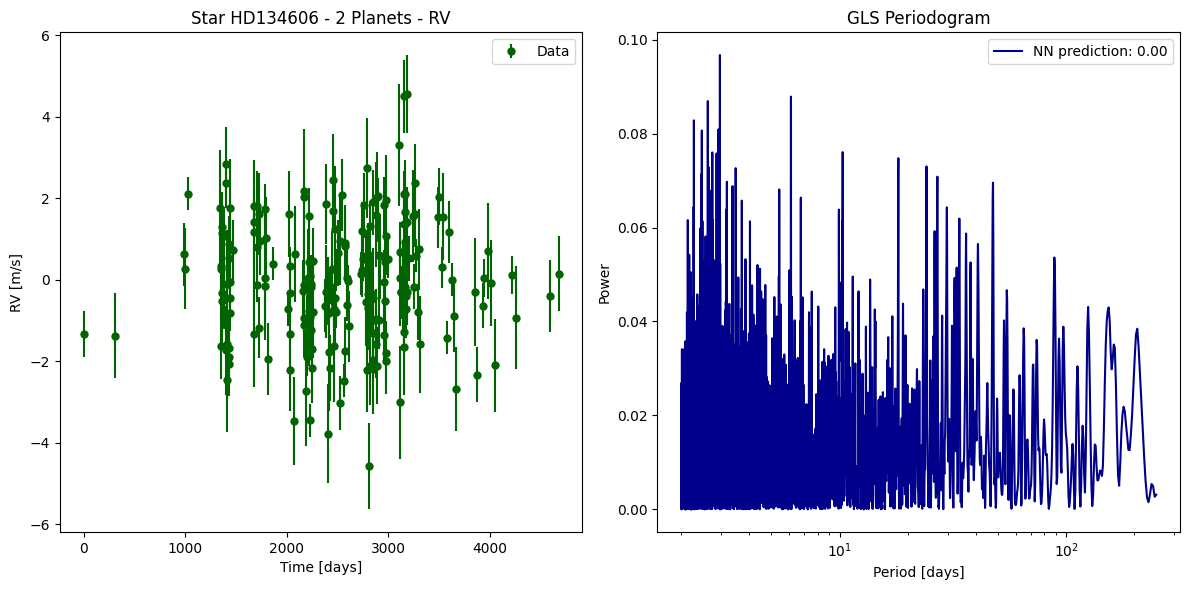

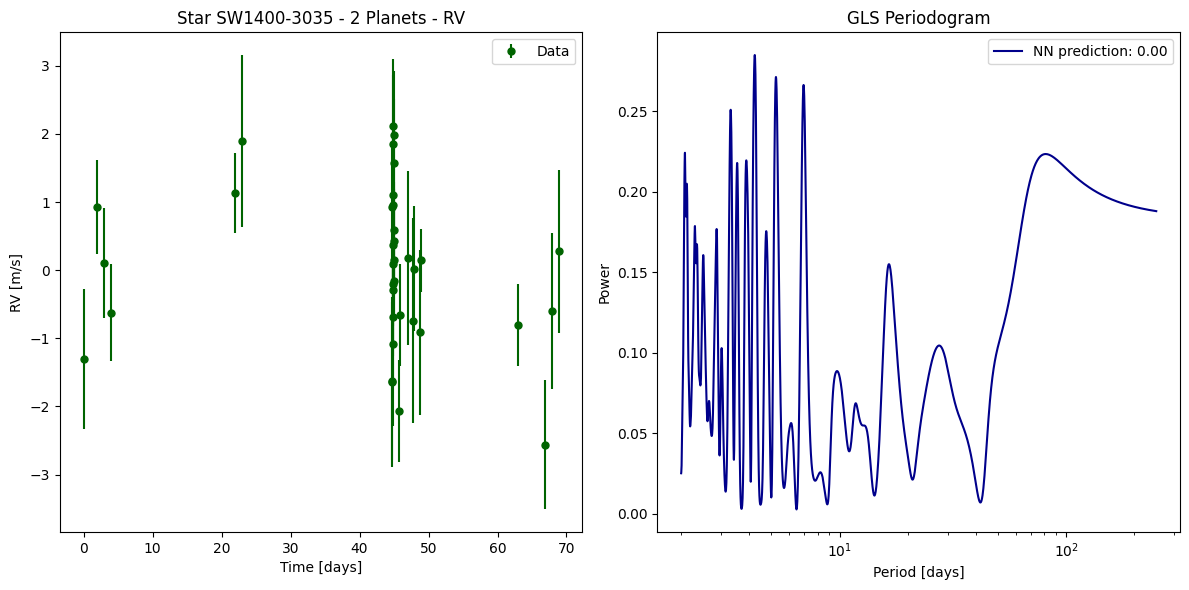

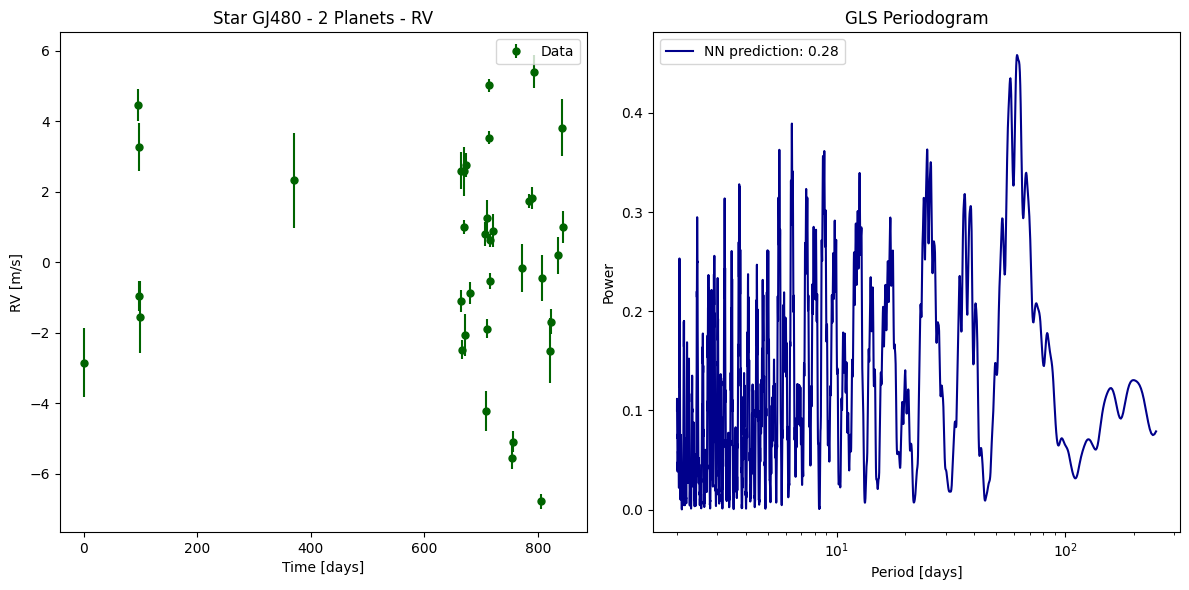

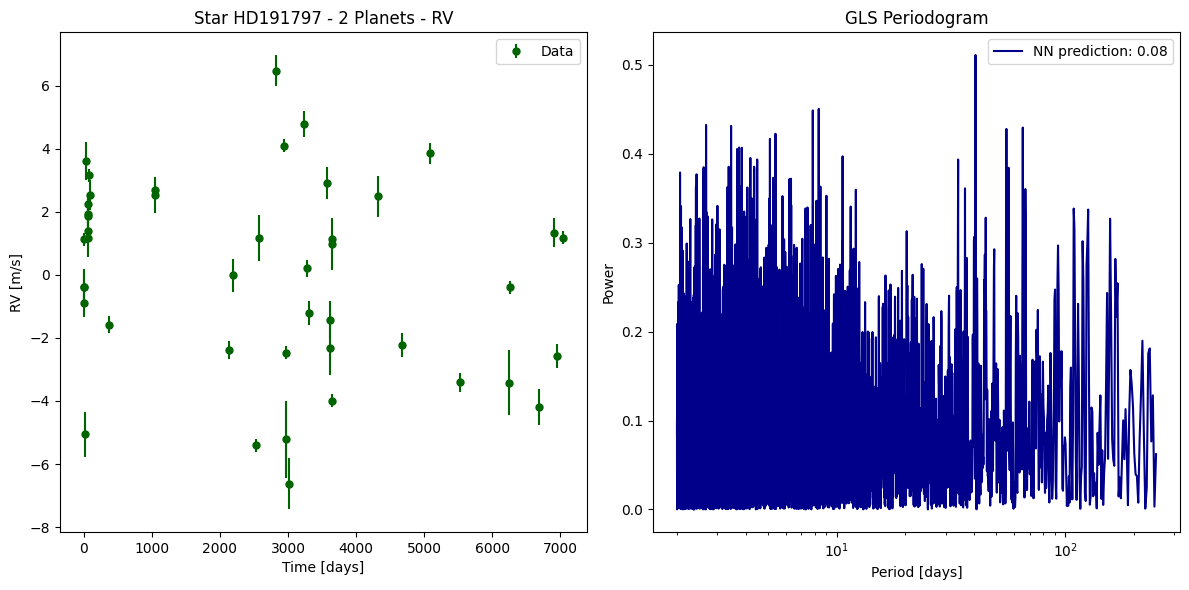

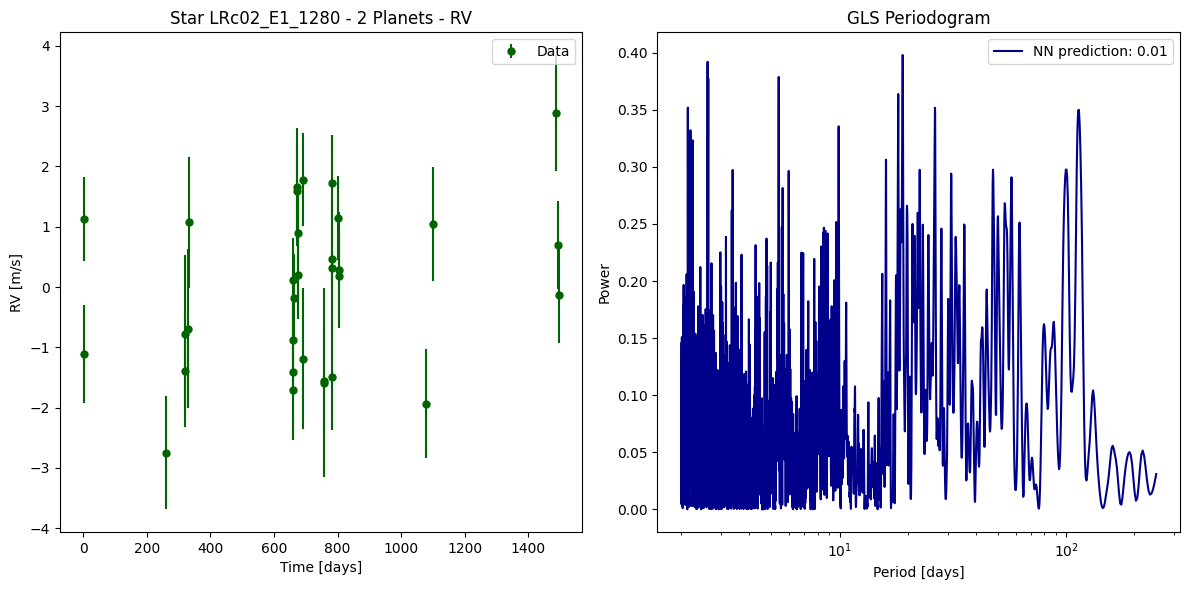

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot

def plot_rv_and_periodogram(data, title_prefix=""):
    
    all_pg, all_t, all_planet_info, all_star_name, all_star_rot, all_peaks_pow, all_labels, all_rv, all_rv_err, prange = data

    all_pg = np.array(all_pg)
    all_peaks_pow = np.array(all_peaks_pow)
    
    all_pg_for_nn = all_pg.reshape(len(all_pg),len(all_pg[0]), 1)
    all_peaks_pow_for_nn = all_peaks_pow.reshape(len(all_peaks_pow),len(all_peaks_pow[0]), 1)
    prediction_nn = network.predict([all_pg_for_nn, all_peaks_pow_for_nn])

    for i in range(len(all_pg)):
        t = np.array(all_t[i])
        rv = np.array(all_rv[i]["rv_star"]) # all_rv[i] is a dictionary.
        err_rv = np.array(all_rv_err[i])
        pg = np.array(all_pg[i])
        peak_pow = np.array(all_peaks_pow[i])
        
        
        periods, amplitudes = [], []
        for planet in all_planet_info[i]:
            periods.append(float(planet["P"]))
            amplitudes.append(float(planet["K"]))
            
        ### Plot
        plt.figure(figsize=(12, 6))


        # Left: RV vs Time
        
        plt.subplot(1, 2, 1)
        plt.errorbar(t, rv, yerr = err_rv,color="darkgreen", fmt = ".",markersize=10, label = "Data")
        plt.xlabel("Time [days]")
        plt.ylabel("RV [m/s]")
        plt.title(f"Star {all_star_name[i]} - {title_prefix} - RV")
        plt.legend()

        # Right: Periodogram
        
        plt.subplot(1, 2, 2)
        plt.plot(prange, pg, '-',color='darkblue', label = f"NN prediction: {prediction_nn[i][0]:.2f}")
        
        for j in range(len(periods)):
            plt.axvline(periods[j], color=plt.cm.tab10(j % 10), linestyle="--",
                              label=fr"P: {periods[j]:.0f} d, K: {amplitudes[j]:.1f} m/s")
            
        plt.xlabel("Period [days]")
        plt.ylabel("Power")
        plt.xscale("log")
        plt.title("GLS Periodogram")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Example usage
plot_rv_and_periodogram(no_planets_data, title_prefix="2 Planets")


In [ ]:
test_pg = np.array(all_pg)
test_pg_err = all_pg_err #no puedo hacerlo array
test_t = all_t #no puedo hacerlo array
test_planet_info = all_planet_info
test_star_name = all_star_name
test_star_rot = np.array(all_star_rot)
test_peaks_pow = np.array(all_peaks_pow)
test_labels = np.array(all_labels)
test_rv = np.array(all_rv)

test_pg = test_pg.reshape(len(test_pg),len(test_pg[0]), 1)
test_peaks_pow = test_peaks_pow.reshape(len(test_peaks_pow),len(test_peaks_pow[0]), 1)

predictions_red = network.predict([test_pg, test_peaks_pow])